In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#other libraries
from tqdm import tqdm
import time
import random
import os
import sys
from pathlib import Path
import h5py

#torch specific
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data

#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *
from imcal import CalorimeterDataset
from imcal import HDF5LazyDataset
from imcal import RandomRoll

In [9]:
#variables controlled by the user. Change these to fit your specific needs.
TRAIN_N_EVENTS = 10 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
TEST_N_EVENTS = 10 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 100 #resolution

#Data specification
LABELS = ["BH_n5_M8TeV", "SPH_9"]
TRAIN_FILENAMES = [f"BH_n5_M8_res{RES}_10000_events.h5", f"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res{RES}_10000_events.h5"]
TEST_FILENAMES = [f"BH_n5_M8_res{RES}_3000_events.h5", f"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res{RES}_3000_events.h5"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
TRAIN_DATAPATH = Path(f"/disk/atlas3/data_MC/2dhistograms/sph_BH/training/{RES}/") #The path to the folder containing the training histogram files
TEST_DATAPATH = Path(f"/disk/atlas3/data_MC/2dhistograms/sph_BH/testing/{RES}/") #The path to the folder containing the testing histogram files

MODEL_NAME = f'resnet_{str(int(time.time()))}' #A unique name for the model
print(MODEL_NAME)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

#Data processing
#filters=["saturate"]
filters=None
transforms = torch.nn.Sequential(
        #torchv.transforms.RandomVerticalFlip(),
        #torchv.transforms.RandomHorizontalFlip(),
        RandomRoll(1)
    )
transforms=None

resnet_1668075473
Running on the GPU


In [4]:

def load_datasets(input_files:list, device, n_events:int, filters=None, transforms=None):
    """ 
    Dataset must be in hdf5 format:
    Event1 /group
        Data /dataset
        Label  /dataset #not used for now
    Event2 /group
        Data  /dataset
        Label  /dataset
    """
    def load_hd5_histogram(path:Path, n_events:int, filters):
        with h5py.File(path, 'r') as f:
            keys = list(f.keys())
            keys = keys[0:n_events]
            data = [f[key]["data"] for key in keys]
            #create array
            arr = np.array(data)
            print(f"Loaded data with {len(arr)} entries of shape {np.shape(arr)}")
            print(f"Check max value: {np.max(arr)}")
            #Filters (normalise etc)
            arr = apply_filters(filters, arr, maxvalue=2000)
            return Tensor(arr)

    def label_maker(n_classes:int, n_events:int):
        #Creates labels for the classes. The first class gets value [1, 0, .., 0], the next [0, 1, ..., 0] etc
        a = torch.zeros(n_events*n_classes, n_classes, dtype=torch.int)
        for i in range(n_classes):
            for j in range(n_events):
                a[n_events*i + j][i] = 1
        return a
    print(f"Loads data with transforms {transforms} and filters {filters}")
    #Loads the data files
    data = [load_hd5_histogram(file, n_events, filters) for file in input_files]
    Cal = torch.cat([item[0:n_events] for item in data]).float().to(device)
    labels = label_maker(len(data), n_events).float().to(device)
    
    #Check everything is ok
    print(f"Data has shape {Cal[0].shape}")
    print(f"There are {len(data)} classes.")

    dataset = CalorimeterDataset(Cal, labels, transform=transforms)
    
    return dataset

In [25]:
class HDF5LazyDataset(data.Dataset):
    #https://towardsdatascience.com/hdf5-datasets-for-pytorch-631ff1d750f5
    """Represents an abstract HDF5 dataset.
    
    Input params:
        file_path: Path to the folder containing the dataset (one or multiple HDF5 files).
        recursive: If True, searches for h5 files in subdirectories.
        load_data: If True, loads all the data immediately into RAM. Use this if
            the dataset is fits into memory. Otherwise, leave this at false and 
            the data will load lazily.
        data_cache_size: Number of HDF5 files that can be cached in the cache (default=3).
        transform: PyTorch transform to apply to every data instance (default=None).
    """
    def __init__(self, file_path, labels, device, recursive, load_data, data_cache_size=3, 
                filters=None, transform=None):
        super().__init__()
        self.data_info = []
        self.data_cache = {}
        self.data_cache_size = data_cache_size
        self.transform = transform
        self.labels = labels
        self.device = device
        self.filters = filters

        # Search for all h5 files
        p = Path(file_path)
        assert(p.is_dir())
        if recursive:
            files = sorted(p.glob('**/*.h5'))
        else:
            files = sorted(p.glob('*.h5'))
        if len(files) < 1:
            raise RuntimeError('No hdf5 datasets found')

        for h5dataset_fp in files:
            self._add_data_infos(str(h5dataset_fp.resolve()), load_data)
            
    def __getitem__(self, index):
        # get data
        print(self.get_data("data", index))
        x = torch.from_numpy(self.get_data("data", index))
        if self.filters != None:
            x = self.apply_filters(self.filters, x)
        if self.transform:
            x = self.transform(x)
        # get label
        value = self.get_data("label", index)
        value = value.decode()
        y = self.label_maker(value, self.labels)
        y = torch.from_numpy(y)
        return (x.to(self.device), y.to(self.device))

    def __len__(self):
        return len(self.get_data_infos('data'))

    def _add_data_infos(self, file_path, load_data):
        with h5py.File(file_path) as h5_file:
            # Walk through all groups, extracting datasets
            for gname, group in h5_file.items():
                for dname, ds in group.items():
                    # if data is not loaded its cache index is -1
                    idx = -1
                    if load_data:
                        # add data to the data cache
                        idx = self._add_to_cache(ds[()], file_path)
                    
                    # type is derived from the name of the dataset; we expect the dataset
                    # name to have a name such as 'data' or 'label' to identify its type
                    # we also store the shape of the data in case we need it
                    self.data_info.append({'file_path': file_path, 'type': dname, 'shape': np.shape(ds[()]), 'cache_idx': idx})

    def _load_data(self, file_path, index):
        """Load data to the cache given the file
        path and update the cache index in the
        data_info structure.
        """
        with h5py.File(file_path) as h5_file:
            gname = f"group_{index}"
            print(gname)
            for dname, ds in h5_file[gname].items():
                print(dname)
                # the cache index
                idx = self._add_to_cache(ds[()], file_path)

                # find the beginning index of the hdf5 file we are looking for
                file_idx = next(i for i,v in enumerate(self.data_info) if v['file_path'] == file_path)

                # the data info should have the same index since we loaded it in the same way
                self.data_info[file_idx + idx]['cache_idx'] = idx
            """for gname, group in h5_file.items():
                for dname, ds in group.items():
                    # add data to the data cache and retrieve
                    # the cache index
                    idx = self._add_to_cache(ds[()], file_path)

                    # find the beginning index of the hdf5 file we are looking for
                    file_idx = next(i for i,v in enumerate(self.data_info) if v['file_path'] == file_path)

                    # the data info should have the same index since we loaded it in the same way
                    self.data_info[file_idx + idx]['cache_idx'] = idx"""

        # remove an element from data cache if size was exceeded
        if len(self.data_cache) > self.data_cache_size:
            # remove one item from the cache at random
            removal_keys = list(self.data_cache)
            removal_keys.remove(file_path)
            self.data_cache.pop(removal_keys[0])
            # remove invalid cache_idx
            self.data_info = [{'file_path': di['file_path'], 'type': di['type'], 'shape': di['shape'], 'cache_idx': -1} if di['file_path'] == removal_keys[0] else di for di in self.data_info]

    def _add_to_cache(self, data, file_path):
        """Adds data to the cache and returns its index. There is one cache
        list for every file_path, containing all datasets in that file.
        """
        if file_path not in self.data_cache:
            self.data_cache[file_path] = [data]
        else:
            self.data_cache[file_path].append(data)
        return len(self.data_cache[file_path]) - 1

    def get_data_infos(self, type):
        """Get data infos belonging to a certain type of data.
        """
        data_info_type = [di for di in self.data_info if di['type'] == type]
        return data_info_type

    def get_data(self, type, i):
        """Call this function anytime you want to access a chunk of data from the
            dataset. This will make sure that the data is loaded in case it is
            not part of the data cache.
        """
        fp = self.get_data_infos(type)[i]['file_path']
        if fp not in self.data_cache:
            self._load_data(fp, i)
        
        # get new cache_idx assigned by _load_data_info
        cache_idx = self.get_data_infos(type)[i]['cache_idx']
        return self.data_cache[fp][cache_idx]
        
    def label_maker(self, value, labels):
    #Creates labels for the classes. The first class gets value [1, 0, .., 0], the next [0, 1, ..., 0] etc
        for i, label in enumerate(labels):
            if value==label:
                idx = i
        vector = np.zeros(len(labels))
        vector[idx] = 1
        return vector

    def apply_filters(self, key_list, image, maxvalue=2000):
        if key_list!=None:
            for key in key_list:
                
                if key=="saturate":
                    image[image>maxvalue] = maxvalue
                
                #normalisation should probably always be last applied filter
                elif key=="normalise":
                    image = (image/maxvalue)
                
                else:
                    print(f"Cannot find {key} filter.")

        return image


In [26]:
#load data in memory

"""
trainpaths = [Path(TRAIN_DATAPATH/file) for file in TRAIN_FILENAMES]
testpaths = [Path(TEST_DATAPATH/file) for file in TEST_FILENAMES]
train_data = load_datasets(trainpaths, device, TRAIN_N_EVENTS, filters, transforms)
test_data = load_datasets(testpaths, device, TEST_N_EVENTS, filters, transforms)"""

#load data lazily to not run out of memory, no method to load only part of the data yet

train_data = HDF5LazyDataset(TEST_DATAPATH, LABELS, device=device, recursive=False, load_data=False, filters=filters, transform=transforms)
#test_data = HDF5LazyDataset(TEST_DATAPATH, LABELS, device=device, recursive=False, load_data=False, filters=filters)


#print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [27]:
def view_data(data, cols, num_classes:int, labels, res,spread):
    
    def matrix_image_plot(ax, label):
        ax.set_ylabel(r"$\phi$ [radians]]", fontsize=12)
        ax.set_xlabel(r"$\eta$", fontsize=12)
        ax.set_title(label, fontsize=14,weight="bold")
        ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=12, pad=5, length=4, width=2)
        ax.tick_params(which="major", length=8)
        ax.tick_params(which="minor", length=6)
        ax.minorticks_on()
    images = np.zeros((num_classes, cols, res, res, 3))
    labels = [[labels[i]]*cols for i in range(num_classes)]
    print(labels)
    k = [[i]*cols for i in range(num_classes)]
    print(k)
    for i in range(len(k)):
        row = k[i]
        row = [item*(spread) for item in row]
        row = [int(item + np.random.randint(1, high = 100)) for item in row]
        k[i] = row
    print(k)
    for i, row in enumerate(k):
        for j, item in enumerate(row):
            images[i][j] = data[item][0].cpu()
    #images = [data[item][0].cpu() for item in k]
    print("Image shape: ", images[0][0].shape)
    #labels = [data[item][1].cpu() for item in k]
    #labels = [label.tolist() for label in labels]

    fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (cols*6, num_classes*6))
    for i in range (len(k)):
        for j in range(cols):
            matrix_image_plot(axs[i][j], str(labels[i][j]))
            axs[i][j].imshow(images[i][j], extent=[-5, 5, -np.pi, np.pi], aspect='auto')



view_data(train_data, 4, CLASSES, LABELS, RES, TRAIN_N_EVENTS)

[['BH_n5_M8TeV', 'BH_n5_M8TeV', 'BH_n5_M8TeV', 'BH_n5_M8TeV'], ['SPH_9', 'SPH_9', 'SPH_9', 'SPH_9']]
[[0, 0, 0, 0], [1, 1, 1, 1]]
[[67, 50, 31, 93], [33, 40, 17, 49]]
group_67
data
label
b'BH_n5_M8'


TypeError: expected np.ndarray (got bytes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[253.94014 316.8167  370.9988  379.87402 383.0651  392.3637  405.26953
 526.089   631.75226]
Looking at image 1790


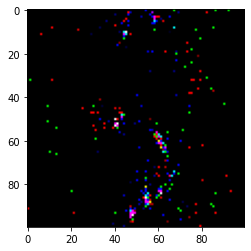

In [110]:
k = np.random.randint(0, len(train_data))
image = train_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


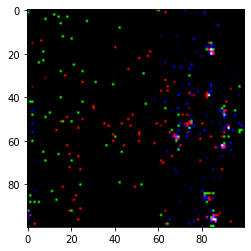

In [78]:
#Check augmentation
transforms = torch.nn.Sequential(
        #torchv.transforms.RandomVerticalFlip(),
        #torchv.transforms.RandomHorizontalFlip(),
        RandomRoll(1),
        RandomRoll(0)
)
if transforms!=None:
    rolled_image = transforms(image)
    plt.imshow(rolled_image)

### Create net and train

In [79]:
#create NN and test that nothing major is wrong.
from resnet import ResNet18
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(device = device)

#testimage, testlabel = traindata.images[0], traindata.img_labels[0]
testimage, testlabel = train_data[0][0], train_data[0][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(device)))

torch.Size([1, 3, 100, 100])
tensor([[0.1086, 0.0009]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [80]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
training_results = train(resnet, train_data, test_data, 2**7, 10, RES, device, optimizer)

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


In [81]:
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(device)))

torch.Size([1, 3, 100, 100])
tensor([[ 1.8801, -1.1731]], device='cuda:0', grad_fn=<AddmmBackward0>)


<AxesSubplot:xlabel='Iteration'>

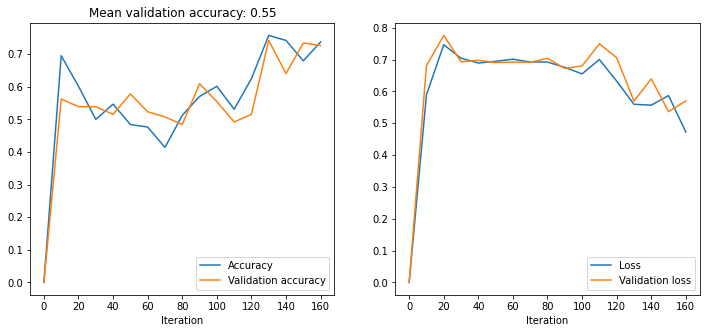

In [95]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
#axs[0].set_ylim(0.6, 1)

In [90]:
from sklearn.metrics import accuracy_score
truth, preds = predict(resnet, test_data, 100, RES, device)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 60/60 [00:00<00:00, 73.22it/s]


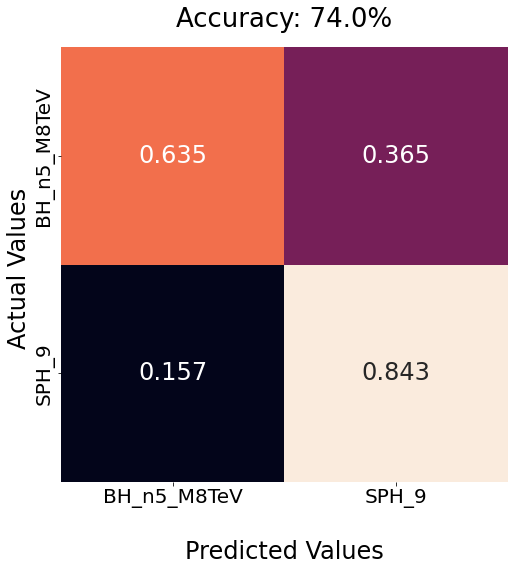

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

fig, ax = plt.subplots(figsize = (8, 8))

#Generate the confusion matrix
cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
cf_matrix = np.round(cf_matrix, 3)
ax = sn.heatmap(cf_matrix, annot=True, cbar=False, cmap='rocket', fmt='g',annot_kws={"size": 24})

#ax.set_title('Confusion matrix\n\n', size=24)
ax.set_xlabel('\nPredicted Values', size=24)
ax.set_ylabel('Actual Values ', size=24)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(LABELS, size=20)
ax.yaxis.set_ticklabels(LABELS, size=20)
ax.set_title(f"Accuracy: {round(accuracy, 2)*100}%", size=26, pad=20)

## Display the visualization of the Confusion Matrix.
plt.show()

In [98]:
#Run n experiments to find statistics on accuracy
from resnet import ResNet18

transforms = torch.nn.Sequential(
        #torchv.transforms.RandomVerticalFlip(),
        #torchv.transforms.RandomHorizontalFlip(),
        RandomRoll(1),
        RandomRoll(0)
)

def experiment(n, n_train, epochs, lr, transforms, filters):
    scores = np.zeros(n)
    train_data = load_datasets(trainpaths, device, n_train, filters, transforms)
    for i in range(n):
        print(f"Iteration {i}")
        resnet = ResNet18(img_channels=3, num_classes=CLASSES)
        resnet.to(device = device)
        optimizer = optim.Adam(resnet.parameters(), lr=lr)
        training_results = train(resnet, train_data, test_data, 2**7, epochs, RES, device, optimizer)
        truth, preds = predict(resnet, test_data, 100, RES, device)
        accuracy = accuracy_score(truth, preds, normalize=True)
        scores[i]= accuracy
    return scores, resnet

results, lastnet = experiment(5, 3000, 10, 0.001, transforms, None)

Loads data with transforms Sequential(
  (0): RandomRoll()
  (1): RandomRoll()
) and filters None
Loaded data with 3000 entries of shape (3000, 100, 100, 3)
Check max value: 17778.150390625
Loaded data with 3000 entries of shape (3000, 100, 100, 3)
Check max value: 12218.7998046875
Data has shape torch.Size([100, 100, 3])
There are 2 classes.
Iteration 0


100%|██████████| 60/60 [00:00<00:00, 75.63it/s]


Iteration 1


100%|██████████| 60/60 [00:00<00:00, 75.37it/s]


Iteration 2


100%|██████████| 60/60 [00:00<00:00, 76.03it/s]


Iteration 3


100%|██████████| 60/60 [00:00<00:00, 75.51it/s]


Iteration 4


100%|██████████| 60/60 [00:00<00:00, 75.60it/s]


In [94]:
#no aug
print(results)
print(results.mean())
print(results.std())

[0.78483333 0.78616667 0.75066667 0.77116667 0.77316667]
0.7732
0.01276992995717326


In [97]:
#eta roll
print(results)
print(results.mean())
print(results.std())

[0.814      0.814      0.81483333 0.79516667 0.78333333]
0.8042666666666667
0.012822982838984394


In [100]:
#eta roll
print(results)
print(results.mean())
print(results.std())

[0.8155     0.80116667 0.80916667 0.78216667 0.7915    ]
0.7999
0.011965505978993677
